In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


df_list = []
for i in range(1, 57):
    file = pd.read_excel(f'Data/{i}.xlsx', dtype= {'Congr. Dist.': str,
                                                   'County Code': str,
                                                   'Zip': str,
                                                   'NAICS, Primary and Small' : str,
                                                   'NAICS, Buy Green and Small': str,
                                                   'NAICS, All (for which firm is small)': str})
    df_list.append(file)

dat = pd.concat(df_list, ignore_index=True).drop_duplicates()
dat = pd.DataFrame(dat)

dat = dat[['Name of Firm', 'Contact', 'E-mail Address', 'Address, line 1', 'City',
       'Congr. Dist.', 'County Code', 'UEI', 'Phone Number', 'State', 'Zip',
       'NAICS, Primary and Small', 'NAICS, Buy Green and Small',
       'NAICS, All (for which firm is small)']]

dat = dat.dropna(subset=['E-mail Address'])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1648\525027729.py:68: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['NAME']):


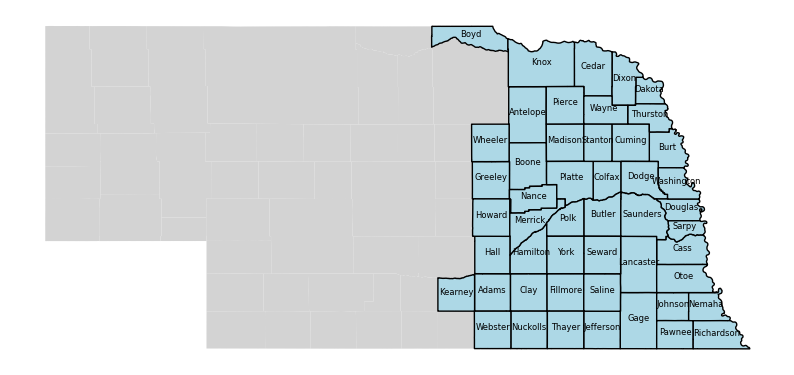

In [10]:
kearney_and_east_counties = [
    ('001', 'Adams'),
    ('003', 'Antelope'),
    ('011', 'Boone'),
    ('015', 'Boyd'),
    ('021', 'Burt'),
    ('023', 'Butler'),
    ('025', 'Cass'),
    ('027', 'Cedar'),
    ('035', 'Clay'),
    ('037', 'Colfax'),
    ('039', 'Cuming'),
    ('043', 'Dakota'),
    ('051', 'Dixon'),
    ('053', 'Dodge'),
    ('055', 'Douglas'),
    ('059', 'Fillmore'),
    ('067', 'Gage'),
    ('077', 'Greeley'),
    ('079', 'Hall'),
    ('081', 'Hamilton'),
    ('093', 'Howard'),
    ('095', 'Jefferson'),
    ('097', 'Johnson'),
    ('099', 'Kearney'),
    ('107', 'Knox'),
    ('109', 'Lancaster'),
    ('119', 'Madison'),
    ('121', 'Merrick'),
    ('125', 'Nance'),
    ('127', 'Nemaha'),
    ('129', 'Nuckolls'),
    ('131', 'Otoe'),
    ('133', 'Pawnee'),
    ('139', 'Pierce'),
    ('141', 'Platte'),
    ('143', 'Polk'),
    ('147', 'Richardson'),
    ('151', 'Saline'),
    ('153', 'Sarpy'),
    ('155', 'Saunders'),
    ('159', 'Seward'),
    ('167', 'Stanton'),
    ('169', 'Thayer'),
    ('173', 'Thurston'),
    ('177', 'Washington'),
    ('179', 'Wayne'),
    ('181', 'Webster'),
    ('183', 'Wheeler'),
    ('185', 'York')
]

county_df = pd.DataFrame(kearney_and_east_counties, columns=['County Code', 'County Name'])

all_counties_df = pd.DataFrame(kearney_and_east_counties, columns=['County Code', 'County Name'])

ne_counties = gpd.read_file('county_boundaries.geojson')

map_data = ne_counties.merge(all_counties_df, left_on='NAME', right_on='County Name', how='right')

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
ne_counties.plot(ax=ax, color='lightgrey')
map_data.plot(ax=ax, color='lightblue', edgecolor='black')

ax.grid(False)
ax.axis('off')

for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['NAME']):
    ax.text(x, y, label, fontsize=6, ha='center', color='black')

plt.title('')

plt.savefig('East of Kearney Counties.png', bbox_inches='tight')
plt.show()

In [3]:
county_dict = county_df.set_index('County Code')['County Name'].to_dict()

def add_county_name(df):
    df['County Name'] = df['County Code'].map(county_dict)
    return df

def get_address(x):
    x['address'] = f"{x['Address, line 1']}, {x['City']}, {x['State']} {x['Zip']}"
    return x

def fill_naics(x):
    x['naics'] = ""
    
    if pd.notna(x['NAICS, Primary and Small']):
        x['naics'] = x['NAICS, Primary and Small']
    elif pd.notna(x['NAICS, All (for which firm is small)']) and isinstance(x['NAICS, All (for which firm is small)'], str):
        x['naics'] = x['NAICS, All (for which firm is small)'][0:6]
    else:
        x['naics'] = ""

    return x

def get_industry(x):
    x['industry'] = x['naics'][0:2]

    return x

dat = add_county_name(dat)
dat = dat.apply(get_address, axis=1)
dat = dat.apply(fill_naics, axis=1)
dat = dat.apply(get_industry, axis=1)

In [4]:
import pandasql as psql

query = """
SELECT *
FROM dat
WHERE industry IN ("23", "52", "54", "56", "51")
"""

eastKearney = psql.sqldf(query, locals())

In [5]:
industry_names = {
    '23': 'Construction',
    '52': 'Finance and Insurance',
    '54': 'Professional, Scientific, and Technical Services',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '51': 'Information'
}

def get_industry_names(x):
    naics_prefix = str(x['naics'])[:2]
    x['industry'] = industry_names.get(naics_prefix, 'Unknown')
    return x

eastKearney = eastKearney.apply(get_industry_names, axis=1)

# eastKearney.to_excel('East of Kearney Business Contacts.xlsx')
eastKearney

,Name of Firm,Contact,E-mail Address,"Address, line 1",City,Congr. Dist.,County Code,UEI,Phone Number,State,Zip,"NAICS, Primary and Small","NAICS, Buy Green and Small","NAICS, All (for which firm is small)",County Name,address,naics,industry
0,"MIDWEST ROOFING, INC",Richard Brunke,Rich@midwestroofing.com,2827 N 20TH ST,LINCOLN,1,109,None,402-466-2957,NE,68521-1812,238160,None,238160,Lancaster,"2827 N 20TH ST, LINCOLN, NE 68521-1812",238160,Construction
1,"Hy-electric, Inc.",Paul A Scheel,pascheel@hy-electric.com,4590 N 48TH ST,LINCOLN,1,109,L95JH9NMZJ34,402-466-6606,NE,68504-1414,None,None,238210,Lancaster,"4590 N 48TH ST, LINCOLN, NE 68504-1414",238210,Construction
2,ROBERT T. LAMBERTON,ROB LAMBERTON,lambertonrake@aol.com,5218 HIGH ST.,LINCOLN,1,109,None,402-560-4098,NE,68506-3427,None,None,"237990, 332212",Lancaster,"5218 HIGH ST., LINCOLN, NE 68506-3427",237990,Construction
3,"TCW CONSTRUCTION, INC.",JOSEPH M DELGADO,jdelgado@tcwconstruction.com,141 M ST,LINCOLN,1,109,None,402-475-5030,NE,68508-2436,237310,None,"236210, 236220, 237110, 237310, 237990, 237990...",Lancaster,"141 M ST, LINCOLN, NE 68508-2436",237310,Construction
4,"ASW ASSOCIATES, INC.",JAN MULLINS,jmullins@airsoilwater.com,8101 O ST STE 119,LINCOLN,1,109,None,402-488-3983,NE,68510-2565,562910,None,"236210, 236220, 237110, 237990, 238910, 518210...",Lancaster,"8101 O ST STE 119, LINCOLN, NE 68510-2565",562910,Administrative and Support and Waste Managemen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,SOUTHERN TITLE LLC,TERESA THEOBALD,southerntitlellc@yahoo.com,117 W 4TH AVE,RED CLOUD,3,181,MVQ8EEKK8ZD8,402-746-2246,NE,68970-2432,None,None,541191,Webster,"117 W 4TH AVE, RED CLOUD, NE 68970-2432",541191,"Professional, Scientific, and Technical Services"
2614,FIGGINS CONSTRUCTION CO INC,DONNA FIGGINS,figginsconstruction@juno.com,1511 RD 1100,RED CLOUD,3,181,NLJSP9HH3FR7,402-746-2559,NE,68970-7080,None,None,237310,Webster,"1511 RD 1100, RED CLOUD, NE 68970-7080",237310,Construction
2615,"AL'S OLD HOUSE REPAIRS, LLC",ARMANDO LEAL JR.,alsoldhouserepair@yahoo.com,804 N SEWARD ST,RED CLOUD,3,181,MLMCUP541WG7,402-746-0564,NE,68970-2120,None,None,"238990, 238990",Webster,"804 N SEWARD ST, RED CLOUD, NE 68970-2120",238990,Construction
2616,"GLENWOOD TELECOMMUNICATIONS, INC.",STANLEY ROUSE,manager@glenwoodtelco.net,510 W GAGE ST,BLUE HILL,3,181,M5UBRBGK2GH7,402-756-3131,NE,68930-8000,None,None,"237130, 238210, 517111, 518210",Webster,"510 W GAGE ST, BLUE HILL, NE 68930-8000",237130,Construction


In [6]:
carlos = []

def split_emails_into_lists(df, column_name, chunk_size=50):
    email_values = df[column_name].tolist()
    email_values = [x for x in email_values if pd.notna(x)]

    email_lists = [';'.join(email_values[i:i + chunk_size]) for i in range(0, len(email_values), chunk_size)]

    return email_lists


email_lists = split_emails_into_lists(eastKearney, 'E-mail Address')
carlos_list = pd.DataFrame(email_lists)

In [7]:
# carlos_list.to_excel('Carlos Emailing List.xlsx')
carlos_list

,0
0,Rich@midwestroofing.com;pascheel@hy-electric.c...
1,mike.losee@firespring.com;yuriyz@itcomputersli...
2,dapatel@huskerit.com;brec.wilshusen@soliden.bi...
3,henry.vargas@1csi.com;gopalrao@achala.com;stev...
4,tsmith2811@gmail.com;carly.grabner@eadengineer...
5,kirkcoll@aol.com;djacobs@prioritytech.com;kent...
6,JCalabretto@CalabrettoBuilding.com;choagland@o...
7,platham@watersolutionsllc.net;tony@cambiumdata...
8,silvesterjuanes@gmail.com;rob@strongoak.us;alg...
9,logan_jessen@hotmail.com;joan@hemenwayassociat...
